In [1]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix
from torch import Tensor

In [27]:
# data parameter
LAG = 15
WAVE = 2
START_RATIO = 0.25

In [28]:
def get_wave_period(wave: int):
    if wave == 1:
        return (52, 103)
    elif wave == 2:
        return (160, 280)
    elif wave == 3:
        return (280, 505)
    elif wave == 4:
        return (757, 871)

In [29]:
def get_z_norm_count(df: pd.DataFrame, wave:int, lag:int):
    wave_start, wave_end = get_wave_period(WAVE)
    _ = df[wave_start - lag: wave_end]
    return (_['count'].mean(), _['count'].std())

In [30]:
def std_column(df: pd.DataFrame, column_name: str)->pd.DataFrame:
    if (df[column_name] == 0).all():
        return df[column_name]
    return (df[column_name] - df[column_name].mean()) / df[column_name].std()

In [32]:
# prepare data
sequence = read_dataframe('all')
count_mean, count_std = get_z_norm_count(sequence, WAVE, LAG)
print(count_mean, count_std)

wave_start, wave_end = get_wave_period(WAVE)
sequence = sequence[wave_start - LAG: wave_end]

for _ in ['avg_temp', 'avg_humid', 'sum', 'count']:
    sequence.loc[:, _] = std_column(sequence, _)

shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
y_train = y_train.reshape(-1, 1)

x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
y_train = torch.from_numpy(y_train.astype('float64')).type(torch.Tensor)  # convert to tensor

wave_x, wave_y = x_train, y_train

30.496296296296297 37.96028444486994


### LSTM Model

In [34]:
class TemporalWeightingLayer(nn.Module):
    def __init__(self, lag):
        super(TemporalWeightingLayer, self).__init__()
        self.lag_importance = nn.Parameter(torch.full((lag,), 10.0))

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, features, lag)
        Returns:
            Amplified tensor of the same shape (batch_size, features, lag)
        """
        weights = torch.sigmoid(self.lag_importance)
        amplified_x = x * weights.view(1, -1, 1)
        return amplified_x


class ScalingResidualLstmModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, lag, dropout=0):
        super(ScalingResidualLstmModel, self).__init__()
        self.scaling = TemporalWeightingLayer(lag)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.residual = nn.Linear(input_size, output_size)
        self.fc2 = nn.Linear(2, output_size)

    def forward(self, x):
        out = self.scaling(x)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        residual = self.residual(x[:, -1, :])  # last timestamp of output only

        out = self.fc2(torch.cat((out, residual), dim=1))
        return out

In [35]:
class CurveLoss(nn.MSELoss):
    def __init__(self, model, lambda_l1, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__(size_average, reduce, reduction)
        self.model = model
        self.lambda_l1 = lambda_l1

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        l1_penalty = 0
        for param in self.model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        return super().forward(input, target) + torch.square(torch.mean(torch.abs(input - target))) + self.lambda_l1 * l1_penalty

In [36]:
# build model
input_dim = x_train.shape[-1]
hidden_dim = 64
num_layers = 4
output_dim = 1
num_epochs = 3_000

model = ScalingResidualLstmModel(input_dim, hidden_dim, num_layers, output_dim, LAG)

In [37]:
# train
# num_epochs = 1_000
# loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.L1Loss()
# loss_fn = torch.nn.SmoothL1Loss()
loss_fn = CurveLoss(model, 1e-5)
# optimiser = torch.optim.Adam(model.parameters(), lr=3e-6)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
min_loss = np.inf
best_model_state = None
model.train()

TRAIN_RANGE = int(np.floor(wave_y.shape[0] * START_RATIO))

y_var = np.var(wave_y.numpy().reshape(-1)[:TRAIN_RANGE])
for epoch in range(1, num_epochs + 1):
    y_pred = model(wave_x[:TRAIN_RANGE])
    loss = loss_fn(y_pred, wave_y[:TRAIN_RANGE])
    if epoch % 100 == 0:
        print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
    if min_loss > loss.item():
        best_model_state = copy.deepcopy(model.state_dict())
        min_loss = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch: 100 | MSE: 1.41E-01 | RRSE: 9.40E-01
Epoch: 200 | MSE: 1.01E-01 | RRSE: 7.95E-01
Epoch: 300 | MSE: 7.73E-02 | RRSE: 6.95E-01
Epoch: 400 | MSE: 7.36E-02 | RRSE: 6.78E-01
Epoch: 500 | MSE: 6.87E-02 | RRSE: 6.55E-01
Epoch: 600 | MSE: 6.48E-02 | RRSE: 6.37E-01
Epoch: 700 | MSE: 6.18E-02 | RRSE: 6.22E-01
Epoch: 800 | MSE: 6.24E-02 | RRSE: 6.25E-01
Epoch: 900 | MSE: 5.73E-02 | RRSE: 5.98E-01
Epoch: 1000 | MSE: 5.66E-02 | RRSE: 5.95E-01
Epoch: 1100 | MSE: 5.42E-02 | RRSE: 5.82E-01
Epoch: 1200 | MSE: 4.97E-02 | RRSE: 5.57E-01
Epoch: 1300 | MSE: 4.03E-02 | RRSE: 5.02E-01
Epoch: 1400 | MSE: 3.74E-02 | RRSE: 4.83E-01
Epoch: 1500 | MSE: 3.72E-02 | RRSE: 4.82E-01
Epoch: 1600 | MSE: 3.64E-02 | RRSE: 4.77E-01
Epoch: 1700 | MSE: 3.57E-02 | RRSE: 4.73E-01
Epoch: 1800 | MSE: 3.52E-02 | RRSE: 4.69E-01
Epoch: 1900 | MSE: 3.54E-02 | RRSE: 4.71E-01
Epoch: 2000 | MSE: 3.47E-02 | RRSE: 4.66E-01
Epoch: 2100 | MSE: 3.41E-02 | RRSE: 4.62E-01
Epoch: 2200 | MSE: 3.54E-02 | RRSE: 4.71E-01
Epoch: 2300 | MSE: 

In [38]:
# model.eval()
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [39]:
# num_epochs = 1000

x_test = wave_x[TRAIN_RANGE].reshape(1, LAG, wave_x.shape[2])
y_pred = []
prediction_range = wave_x.shape[0] - TRAIN_RANGE
blind_prediction_range = 7
for j in range(prediction_range // blind_prediction_range + 1):
    train_start_index = TRAIN_RANGE + j * blind_prediction_range
    for i in range(blind_prediction_range):
        if train_start_index + i >= len(wave_x):
            break
        _ = model(x_test)
        x_test = wave_x[train_start_index + i].reshape(1, LAG, wave_x.shape[2])
        x_test[0][-1][0] = torch.tensor(_.item())
        _2 = _.detach().numpy()  # revert from tensor
        _2 = _2.reshape(-1)  # reshape back to normal list
        y_pred.append(_2)
    for epoch in range(1, num_epochs + 1):
        _3 = model(wave_x[train_start_index : train_start_index + blind_prediction_range])
        loss = loss_fn(_3, wave_y[train_start_index : train_start_index + blind_prediction_range])
        if epoch % 100 == 0:
            print("Epoch: %d | MSE: %.2E | RRSE: %.2E" % (epoch, loss.item(), np.sqrt(loss.item() / y_var)))
        if min_loss > loss.item():
            best_model_state = copy.deepcopy(model.state_dict())
            min_loss = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

y_pred = np.array(y_pred).reshape(-1)  # reshape back to normal list
print("sample prediction:  ", y_pred)

y_train_sample = wave_y[TRAIN_RANGE:].detach().numpy().reshape(-1)[:prediction_range]
print("sample true result: ", y_train_sample)

mse = sum((y_train_sample - y_pred) ** 2) / len(y_pred)
rmse = mse / np.var(y_train_sample)
print("TEST | MSE: %.2E | RRSE: %.2E" % (mse, rmse))

Epoch: 100 | MSE: 5.69E-01 | RRSE: 1.89E+00
Epoch: 200 | MSE: 3.50E-01 | RRSE: 1.48E+00
Epoch: 300 | MSE: 8.48E-02 | RRSE: 7.28E-01
Epoch: 400 | MSE: 2.84E-02 | RRSE: 4.21E-01
Epoch: 500 | MSE: 2.58E-02 | RRSE: 4.02E-01
Epoch: 600 | MSE: 2.38E-02 | RRSE: 3.86E-01
Epoch: 700 | MSE: 2.22E-02 | RRSE: 3.72E-01
Epoch: 800 | MSE: 2.08E-02 | RRSE: 3.61E-01
Epoch: 900 | MSE: 1.96E-02 | RRSE: 3.50E-01
Epoch: 1000 | MSE: 1.86E-02 | RRSE: 3.41E-01
Epoch: 1100 | MSE: 1.77E-02 | RRSE: 3.33E-01
Epoch: 1200 | MSE: 1.69E-02 | RRSE: 3.25E-01
Epoch: 1300 | MSE: 1.62E-02 | RRSE: 3.18E-01
Epoch: 1400 | MSE: 1.56E-02 | RRSE: 3.12E-01
Epoch: 1500 | MSE: 1.50E-02 | RRSE: 3.06E-01
Epoch: 1600 | MSE: 1.44E-02 | RRSE: 3.00E-01
Epoch: 1700 | MSE: 1.39E-02 | RRSE: 2.95E-01
Epoch: 1800 | MSE: 1.34E-02 | RRSE: 2.90E-01
Epoch: 1900 | MSE: 1.30E-02 | RRSE: 2.85E-01
Epoch: 2000 | MSE: 1.26E-02 | RRSE: 2.80E-01
Epoch: 2100 | MSE: 1.22E-02 | RRSE: 2.76E-01
Epoch: 2200 | MSE: 1.18E-02 | RRSE: 2.72E-01
Epoch: 2300 | MSE: 

In [40]:
y_pred_lstm = copy.deepcopy(y_pred)
mse_lstm = mse

### Plot Result

In [41]:
model.scaling.lag_importance.data

tensor([ 1.7267e+00,  2.9566e-01,  7.3098e-01,  8.2070e-01, -2.9812e-02,
         1.4453e+00,  1.1273e+00,  1.3342e+00, -2.1926e-01, -4.7193e-01,
         1.9785e+00, -2.9448e-01,  1.6958e+00,  4.6737e-01, -3.8782e-05])

In [44]:
y_given = wave_y.detach().numpy().reshape(-1)
y_given = y_given * count_std + count_mean
y_train_sample = y_train_sample * count_std + count_mean
y_pred_lstm = y_pred_lstm * count_std + count_mean

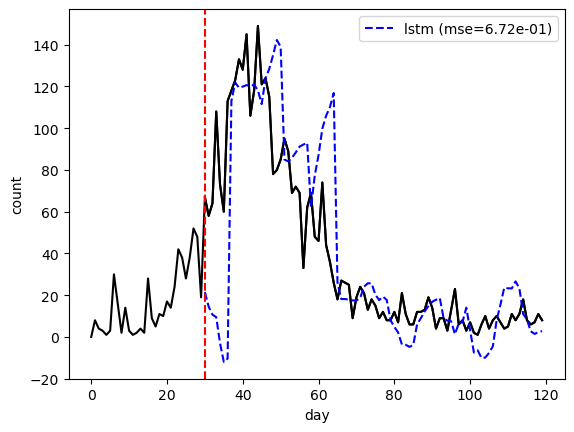

In [45]:

plt.plot(range(len(y_given)), y_given, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_train_sample, color='black')
plt.plot(range(TRAIN_RANGE, len(y_given)), y_pred_lstm, 'b--', label='lstm (mse={mse:.2e})'.format(mse=mse_lstm))
plt.axvline(x=TRAIN_RANGE, linestyle='--', color='red')
plt.ylabel("count")
plt.xlabel("day")
plt.legend()
plt.show()